# Identifying Applications With Java Installed

### Imports

In [97]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import re
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

### Load Data

In [98]:
df = pd.read_excel('cmdb apps.xlsx', 'Business Applications')
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
df.head(5)

,number,name,u_tier_level,subcategory,u_functional_category,install_type,it_application_owner,owned_by,support_group,operational_status,install_status,u_it_group,application_category,u_storm_app
0,APM0004100,3D Monicore - OT System,Business Supported,Nuclear,Nuclear,On Premise,Cassandra Billings,Christopher Niffenegger,NaN,Operational,In Production,Nuclear,NUCL: Nuclear,False
1,APM0002076,3DWINR OT,Business Supported,Nuclear,Nuclear,On Premise,Victor Keyes,Roosevelt Holmes,CSG GGNS,Operational,In Production,Nuclear,NUCL: Nuclear,False
2,APM0002568,ABMR - AUTOMATED BULK MAIL ROUTING,Tier 2,Customer Care,Utility,On Premise,Cecilia Shelton,Chrissoula Ratner,ABMR SUPPORT,Operational,In Production,Utility Customer Service,UCS: Utility Customer Service,False
3,APM0003713,Acadia,Tier 3,Nuclear,Nuclear,On Premise,Ryan Cope,Rodney Bateman,NUCLEAR SUPPORT,Operational,In Production,Nuclear,NUCL: Nuclear,False
4,APM0004103,ACCESS,Tier 3,Software,CBS,On Premise,Vincent Melerine,Linda Pessin,Atos.L1.Service.Desk,Operational,In Production,Workplace Computing,IT: Workplace Computing,False


### Create Application List

In [99]:
apps = df[["name"]]
apps["name"] = apps["name"].str.lower()
apps["name"] = apps["name"].str.replace('[^\w\s]','')
app_list = apps["name"].tolist()
app_list.extend(["ibm", "infa", "openshift", "elasticsearch", "documentum", "dctm", "snow", "informatica", "opentext", "tibcodv", "jfrog", "taxware", "eclipse adoptium", "sas",
                 "datacert"])

In [100]:
command_df = pd.read_excel("Kelly List of Servers.xlsx", "command")
command_df.columns = command_df.columns.str.lower()
command_df.head(5)

,computer,command
0,jdcupcdhdw301,./infa_rpm.tar/jre/bin/java
1,jdcupcdhdw302,./infa_rpm.tar/jre/bin/java
2,jdcupcdhdw303,./infa_rpm.tar/jre/bin/java
3,jdcupcdhdw304,./infa_rpm.tar/jre/bin/java
4,jdcupcdhdw305,./infa_rpm.tar/jre/bin/java


### Create Commands Data 

In [101]:
command_df = pd.read_excel("cmdb_java.xlsx", "server_list")
commanddf = command_df
command_df.columns = command_df.columns.str.lower()
commanddf["command"] = commanddf["command"].str.lstrip("./")
commanddf["command"] = commanddf["command"].str.lower()
commanddf["command"] = commanddf['command'].apply(lambda s: s.split("/") if "/" in s else s.split("\\"))
commanddf["command"] = commanddf['command'].apply(lambda x: [s for s in x if s not in ["app", "apps","", "local", "home", "opt", "etc", "bin"]])
commanddf["command"] = commanddf['command'].apply(lambda x: [s for s in x if s in ["arc", "b2b", "cmd", "dis", "hsm", "ivr", "mig", "pds", "sar", "ibm"] or len(s) > 3])
commanddf = commanddf.groupby(["computer"]).sum()['command'].apply(lambda x: list(set(x))).reset_index()


In [102]:
command_df = pd.read_excel("cmdb_java.xlsx", "server_list")

### Finding Applications

In [103]:
import difflib
from nltk.stem import PorterStemmer

def is_java(s, found_apps):
    if "oracle java" not in found_apps and "zingjava" not in s:
        return any([x in s for x in ("java", "oracle", "oraoem")])


def is_prefix_similarity(str1, str2, app_stem, found_apps):
    if app_stem in found_apps: return False
    if " " in app_stem: return False
    if len(str1) < len(str2): return str2.startswith(str1)
    if len(str2) < len(str1): return str1.startswith(str2)
    if len(str1) < len(str2): return str1 in str2
    if len(str2) < len(str1): return str2 in str1

def find_applications(command, applications):
    found_apps = []
    not_found_apps = []

    stemmer = PorterStemmer()

    for cmd in command:
        matched = False 
        cmd_stem = stemmer.stem(cmd)
        cmd_alpha = re.sub(r"\W+", "", cmd)

        if is_java(cmd_alpha, found_apps):
            found_apps.append("oracle java")
            continue

        for app in applications:
            app_stem = stemmer.stem(app)
            app_alpha = re.sub(r"\W+", "", app_stem)
            
            if cmd_stem == app_stem:
                if app not in found_apps:
                    found_apps.append(app)
                    matched = True
                    break
                else:
                    break
            else:
                if (" " not in app_stem and app not in found_apps and difflib.SequenceMatcher(None, cmd_alpha, app_alpha).ratio() > 0.9) or is_prefix_similarity(cmd_alpha, app_alpha, app_stem, found_apps):
                    found_apps.append(app)
                    matched = True
                    break
        if not matched:
            not_found_apps.append(cmd)

    return found_apps, not_found_apps

commanddf[['Found Applications', 'Not Found']] = commanddf.apply(lambda row: pd.Series(find_applications(row['command'], app_list)), axis=1)
commanddf['Found Applications'] = [list(set(name)) for name in commanddf["Found Applications"]]

for i in range(len(commanddf["Found Applications"])):
    if len(commanddf["Found Applications"][i]) > 1 and "oracle java" in commanddf["Found Applications"][i]:
        commanddf["Found Applications"][i].remove("oracle java")



### Data Trends

In [104]:
java = pd.read_excel('Active VITS Java Servers 20230710.xlsx', 'Active Java VITS Server List')
java = java.drop(columns = [], axis = 1)

java["VIT Proof Data"] = java["VIT Proof Data"].apply(lambda x: "" if pd.isnull(x) else x)
java["CMDB Running Processes"] = java["CMDB Running Processes"].apply(lambda x: "" if pd.isnull(x) else x)

# Finds whatever is in CMDB Running Processes that is not in VIT Proof Data
z = lambda x: set(x["CMDB Running Processes"].split(",")).difference(set(x["VIT Proof Data"].split(",")))
java['Difference'] = java.apply(z, axis=1)

java["Difference"] = java["Difference"].apply(lambda x: set() if "None" in x else x)

### VIT Proof Data and Active VITS Counts

In [105]:
# Count VIT Proof Data and Active VITS and sort Counts descending, display top 5
java.groupby("VIT Proof Data")[["Active VITS"]].count().sort_values(["Active VITS"], ascending = False)[0:5]

,Active VITS
VIT Proof Data,
Oracle Java,243
Tripwire,188
TIBCO,163
"Oracle Java, Tripwire",128
"Tripwire, TIBCO",91


### Tripwire and Active VITS Counts

In [106]:
java.groupby("Tripwire Java Removed")[["Active VITS"]].count().sort_values(["Active VITS"], ascending = False)

,Active VITS
Tripwire Java Removed,
False,614
True,468


### Server and Tripwire Java Removed Counts

In [107]:
# Server Present and Tripwire Java Removed Counts
java.groupby(["Server Present"])["Tripwire Java Removed"].value_counts().reset_index(name = "Counts")

,Server Present,Tripwire Java Removed,Counts
0,False,True,273
1,False,False,192
2,True,False,422
3,True,True,195


### Top Active VITS

In [108]:
# Sort active VITS by decreasing order and look at server name and VIT Proof Data
active_vits = java.sort_values(["Active VITS"], ascending = False)
active_vits_sub = active_vits[["Server Name", "CMDB Running Processes", "VIT Proof Data", "Tripwire Java Removed", "Active VITS"]]

### Inactive VITS = 0

In [109]:
# Filter for Inactive VITS = 0
# Notes: All server_present is false except for 1 true. All VIT Proof Data is Oracle Java only except for one Tripwire and one BMC Patrol
Inactive_vits_0 = java[java["Inactive VITS"] == 0]
Inactive_vits_0 = Inactive_vits_0.drop(["CMDB CI Application List", "Java Licensable Products", "Bundled Java Products", "Non-Oracle Java Products"], axis = 1)

### Mean Active VITS for Server Present

In [110]:
# Find average Active VITS for Server Present True vs. False
java.groupby("Server Present").agg({"Active VITS": "mean"}).rename(columns = {"Active VITS": "Mean Active VITS"}).reset_index()

,Server Present,Mean Active VITS
0,False,14.550538
1,True,24.278768


### Linear Regression

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

data = OneHotEncoder().fit_transform(java[["Server Present"]].values).toarray()
target = java[["Active VITS"]].values

linear_model = LinearRegression().fit(X = data, y = target)
predicted = linear_model.predict(data)
mse = mean_squared_error(target, predicted)
r2 = r2_score(target, predicted)

mean_active_vits = np.mean(java["Active VITS"])
baseline = np.full(predicted.shape, mean_active_vits)
mse_baseline = mean_squared_error(target, baseline)
r2_baseline = r2_score(target, baseline)

print("Model MSE:", mse)
print("Model r^2:", r2)
print("Model Baseline MSE:", mse_baseline)
print("Model Baseline r^2:", r2_baseline)

Model MSE: 121.12672294773454
Model r^2: 0.16070394023663348
Model Baseline MSE: 144.31942285286712
Model Baseline r^2: 0.0


#### Linear Regression Analysis

Some evidence of a correlation between whether the server was present in the KPMG 2021/2022 Study and the number of Active VITS.
$R^2 = 0.16$ indicates a weak correlation.

### Java Graphs

In [112]:
java1 = pd.read_excel('Active VITS Java Servers 20230710.xlsx', 'Active Java VITS Server List')
java = java1[["Server Name", "VIT Proof Data"]]
java = java.drop(columns = [], axis = 1)
java = java.drop_duplicates()
java = java.drop([808])

In [113]:
java["VIT Proof Data"] = java["VIT Proof Data"].apply(lambda x: "" if pd.isnull(x) else x)
java["VIT Proof Data"] = java["VIT Proof Data"].apply(lambda x: x.replace("SmartrBear", "SmartBear").replace("Open Text", "OpenText").replace("Opentext", "OpenText").replace("Oracle java", "Oracle Java"))


final_set = []
for row in java["VIT Proof Data"]:
    final_set += row.split(",")

for el in java["VIT Proof Data"]:
    if el == "":
        final_set.remove(el)
    if el == " ":
        final_set.remove(el)

for idx, el in enumerate(final_set):
     final_set[idx]= el.lstrip().rstrip()

final_list = final_set
final_set = set(final_list)

#### Top 5 Applications With Java Most Counts

In [114]:
counts_dic = collections.Counter(final_list)

counts_df = pd.DataFrame([[key,value] for key,value in counts_dic.items()],
     columns=["App","Counts"])

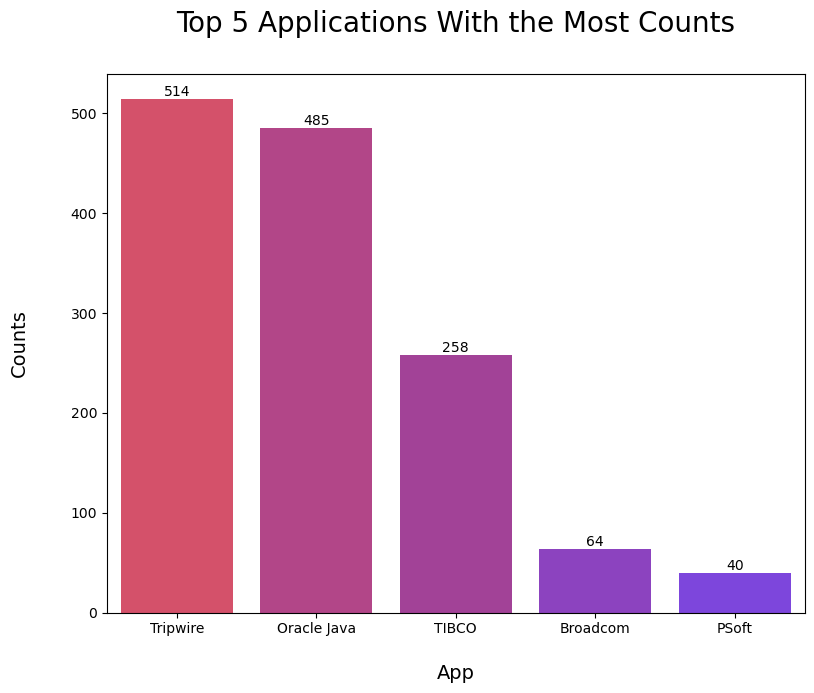

In [115]:
bar_df = counts_df.sort_values(by = "Counts", ascending = False)
bar_df = bar_df.head(5)
plt.figure(figsize = (9, 7))
plt.title("Top 5 Applications With the Most Counts", fontsize = 20, pad = 30)
plt.xlabel("Application", size = 14, labelpad = 20)
plt.ylabel("Counts", size = 14, labelpad = 30)
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(x = "App", y = "Counts", data = bar_df)
ax.bar_label(ax.containers[0])

plt.savefig('seaborn1.png', 
           transparent=True)

plt.show()

#### Top 5 Assignment Groups With Most Counts of Servers With Java Installs NOT Running

In [116]:
java_none = java1[java1["CMDB Running Processes"] == "None"]
java_none.columns = java_none.columns.str.replace(' ', '_')
java_none["VIT_Assignment_Groups"] = java_none["VIT_Assignment_Groups"].apply(lambda x: x.split(" / "))
java_none = java_none[["Server_Name", "VIT_Assignment_Groups"]]
test = java_none.head(10)

vals = java_none.VIT_Assignment_Groups.values.tolist()    
rs = [len(r) for r in vals]    
Server_Name = np.repeat(java_none.Server_Name, rs)

java_none = pd.DataFrame(np.column_stack((Server_Name, np.concatenate(vals))), columns= java_none.columns)
java_none_support = java_none["VIT_Assignment_Groups"].value_counts().reset_index(name = "Counts").head(6)
java_none_support.rename(columns = {'index':'Group'}, inplace = True)
java_none_support = java_none_support.drop(labels=0, axis=0)

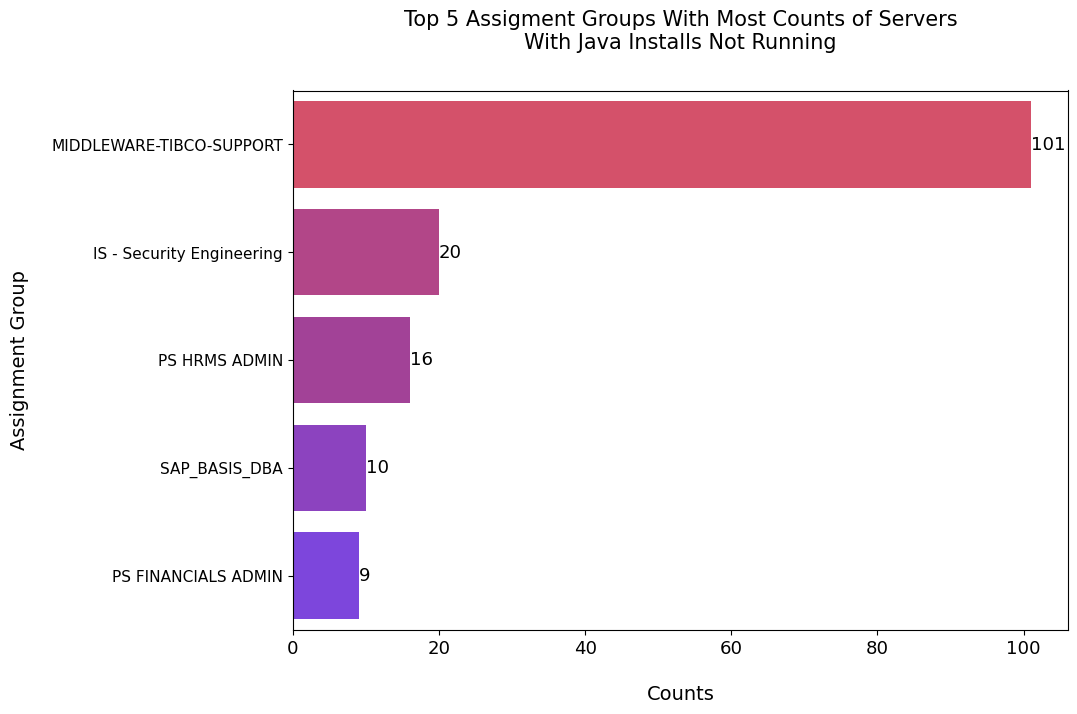

In [117]:
plt.figure(figsize = (10, 7))
plt.title("Top 5 Assigment Groups With Most Counts of Servers\nWith Java Installs Not Running", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Group", data = java_none_support)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Assignment Group", size = 14, labelpad = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11)
ax1.bar_label(ax1.containers[0], size = 13)

plt.savefig('assignment_groups.png', 
           transparent=True, bbox_inches='tight')

plt.show()

#### Top 5 Servers With Java Installs Not Running

In [118]:
java_none_servers = java_none["Server_Name"].value_counts().reset_index(name = "Counts").head(5)
java_none_servers.rename(columns = {'index':'Server'}, inplace = True)

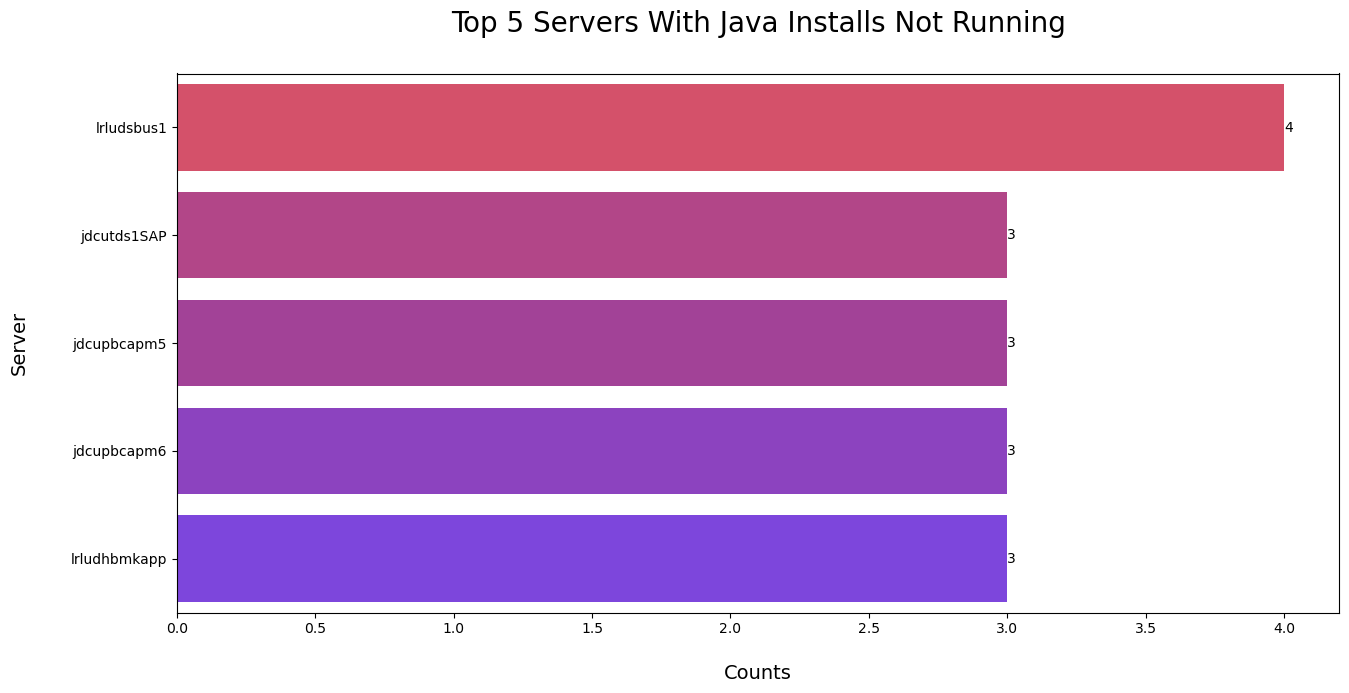

In [119]:
plt.figure(figsize = (15, 7))
plt.title("Top 5 Servers With Java Installs Not Running", fontsize = 20, pad = 30)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Server", size = 14, labelpad = 30)
ax2 = sns.barplot(x = "Counts", y = "Server", data = java_none_servers)
ax2.bar_label(ax2.containers[0])

plt.savefig('assignment_groups.png', 
           transparent=True)

plt.show()